<h1><center> Time Series Analysis with RNN and LSTM using PyTorch</center></h1>

Time series analysis is a statistical technique that deals with time-dependent data, such as stock prices, weather patterns, and sensor data. It involves analyzing patterns in the data to make predictions or gain insights into the underlying processes. Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) are popular neural network models for time series analysis.

<div style="text-align:center"><img src="rnn-vs-lstm.png" /></div>



Refrence: https://ashutoshtripathi.com/

### Recurrent Neural Networks (RNN)

A Recurrent Neural Network (RNN) is a type of neural network that can process sequential data. It has a feedback loop that allows it to take previous outputs as input for the next step. This feedback loop allows the network to learn temporal dependencies in the data. RNNs are commonly used for natural language processing, speech recognition, and time series analysis.

Installing torch: https://pytorch.org/get-started/locally/

PyTorch Example
Here's an example of how to implement an RNN using PyTorch:

In [1]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(hidden[-1, :, :])
        return out


This code creates an RNN model with a single RNN layer with a hidden size of 64 and an input size of input_size. The model then adds a linear layer with an output size of output_size. Finally, the forward method computes the output of the RNN by passing the input x through the RNN layer and then through the linear layer.

### Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) is a type of RNN that can learn long-term dependencies in the data. Unlike regular RNNs, LSTMs have a memory cell that can store information over a long period of time. This memory cell allows the network to remember important information and forget irrelevant information.

PyTorch Example
Here's an example of how to implement an LSTM using PyTorch:

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = self.fc(hidden[-1, :, :])
        return out


This code creates an LSTM model with a single LSTM layer with a hidden size of 64 and an input size of input_size. The model then adds a linear layer with an output size of output_size. Finally, the forward method computes the output of the LSTM by passing the input x through the LSTM layer and then through the linear layer.

#### Example

Let's say we have a dataset of monthly sales data for a retail store, and we want to use an LSTM model to predict sales for the next 6 months based on the previous 12 months of sales data.

#### Solution
Here's an example of how to implement an LSTM model to predict sales using PyTorch:

In [11]:
# Author: Robert Guthrie from pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)


tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward0>))


In [12]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [13]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [14]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.1389, -1.2024, -0.9693],
        [-1.1065, -1.2200, -0.9834],
        [-1.1286, -1.2093, -0.9726],
        [-1.1190, -1.1960, -0.9916],
        [-1.0137, -1.2642, -1.0366]])
tensor([[-0.0462, -4.0106, -3.6096],
        [-4.8205, -0.0286, -3.9045],
        [-3.7876, -4.1355, -0.0394],
        [-0.0185, -4.7874, -4.6013],
        [-5.7881, -0.0186, -4.1778]])


<h1><center> Convolutional Neural Network (CNN)</center></h1>

A Convolutional Neural Network (CNN) is a type of neural network commonly used for image processing and computer vision tasks. It uses convolutional layers to extract features from images and pooling layers to reduce the dimensions of the features. These features are then passed through fully connected layers for classification.

A CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers. Here's a brief explanation of each layer:

Convolutional Layer - This layer applies a set of learnable filters (kernels) to the input image to extract features. Each filter slides over the image and performs element-wise multiplication followed by summation, resulting in a feature map. The output of this layer is a set of feature maps that capture different features of the image.

ReLU Layer - This layer applies the Rectified Linear Unit (ReLU) activation function to the output of the convolutional layer. The ReLU function is used to introduce non-linearity into the network and has been shown to improve the accuracy of CNNs.

Pooling Layer - This layer reduces the spatial dimensions of the feature maps by downsampling the image. The most commonly used pooling operation is max pooling, which selects the maximum value in each pooling window.

Fully Connected Layer - This layer takes the flattened output from the previous layers and applies a set of weights to each neuron to make a prediction. The output of this layer is the predicted class probabilities.

<div style="text-align:center"><img src="CNN.png" /></div>





Refrence: https://medium.com/@mikecavs


Here's an example of a CNN in PyTorch that classifies images of handwritten digits from the MNIST dataset:



In [15]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In this example, the CNN class defines a CNN with two convolutional layers, two ReLU activation layers, two max pooling layers, and two fully connected layers. The Conv2d layers perform the convolution operation with a kernel size of 3 and padding of 1 to preserve the input image size. The MaxPool2d layers perform max pooling with a kernel size of 2 and stride of 2 to reduce the spatial dimensions of the feature maps. The Linear layers perform the fully connected operation to classify the input images into 10 classes.

To train the model, you can use the MNIST dataset, which consists of 60,000 training images and 10,000 test images of handwritten digits. 

In [16]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Load the MNIST dataset
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Define the training parameters
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Create an instance of the CNN class
cnn = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the CNN model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the CNN model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the CNN on the 10000 test images: {} %'.format(100 * correct / total))


7.3%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%
2.0%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Step [100/600], Loss: 0.2704
Epoch [1/5], Step [200/600], Loss: 0.2233
Epoch [1/5], Step [300/600], Loss: 0.0507
Epoch [1/5], Step [400/600], Loss: 0.1864
Epoch [1/5], Step [500/600], Loss: 0.0815
Epoch [1/5], Step [600/600], Loss: 0.0389
Epoch [2/5], Step [100/600], Loss: 0.0428
Epoch [2/5], Step [200/600], Loss: 0.1667
Epoch [2/5], Step [300/600], Loss: 0.0367
Epoch [2/5], Step [400/600], Loss: 0.0251
Epoch [2/5], Step [500/600], Loss: 0.0366
Epoch [2/5], Step [600/600], Loss: 0.0333
Epoch [3/5], Step [100/600], Loss: 0.0352
Epoch [3/5], Step [200/600], Loss: 0.0288
Epoch [3/5], Step [300/600], Loss: 0.0149
Epoch [3/5], Step [400/600], Loss: 0.0884
Epoch [3/5], Step [500/600], Loss: 0.0284
Epoch [3/5], Step [600/600], Loss: 0.0035
Epoch [4/5], Step [100/600], Loss: 0.0180
Epoch [4/5], Step [200/600], Loss: 0.0039
Epoch [4/5

<h1><center> Task -1 </center></h1>

Build a simple CNN model in PyTorch to classify images of the CIFAR-10 dataset. 

The model should have two convolutional layers, two max pooling layers, and two fully connected layers. 

Train the model on the CIFAR-10 training set for 5 epochs with a batch size of 100 and a learning rate of 0.001. 

Evaluate the model on the CIFAR-10 test set and print the accuracy.


In [24]:
## Assistance to load the dataset - only for sample

import torchvision

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


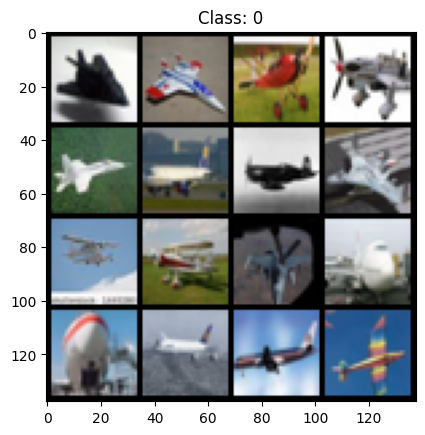

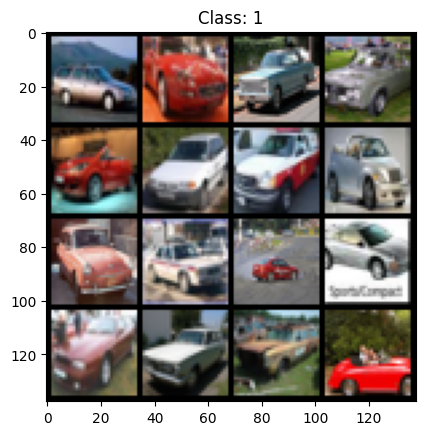

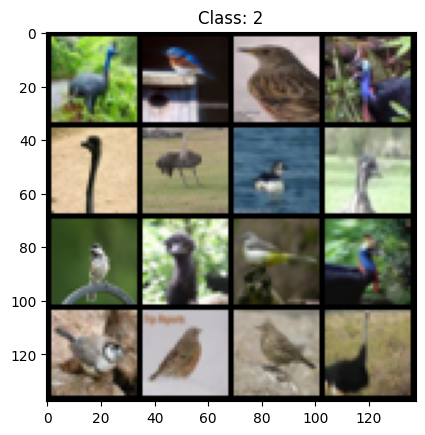

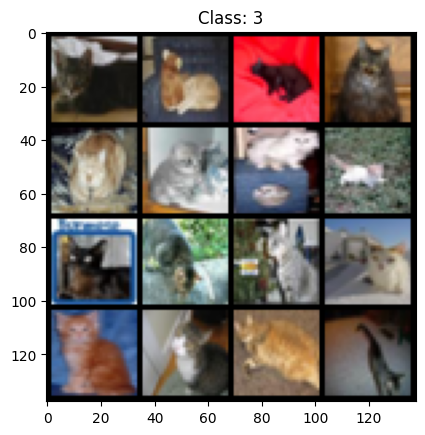

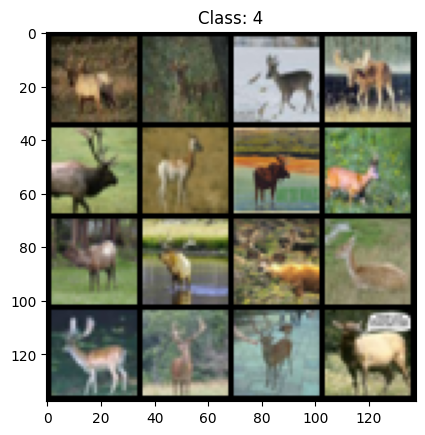

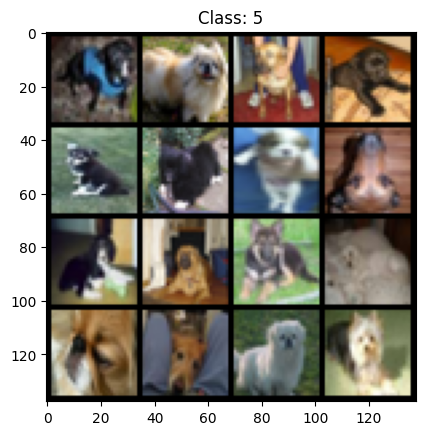

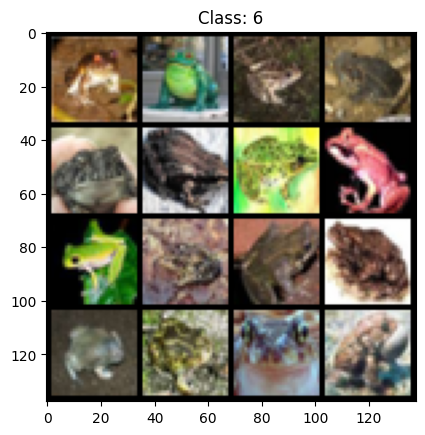

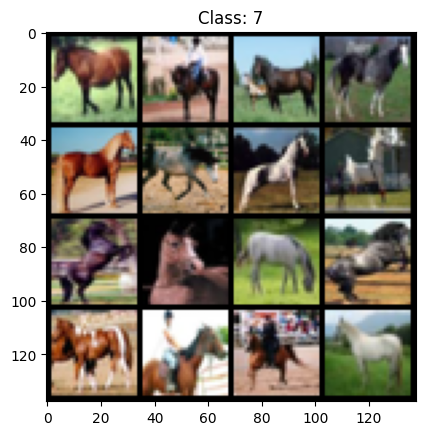

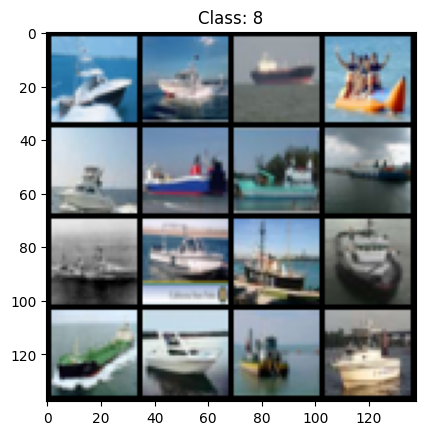

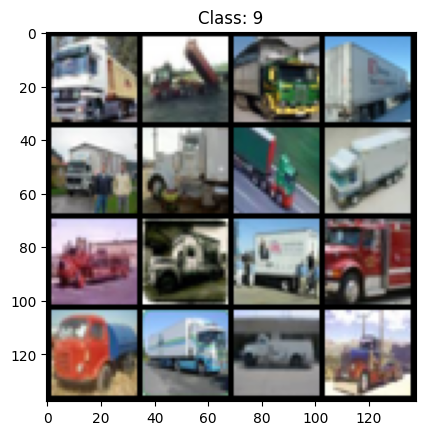

In [31]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Load the CIFAR-10 dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Create a list to store the images of each class
classes_images = [[] for i in range(10)]

# Iterate over the dataset and add each image to its corresponding class
for image, label in train_dataset:
    classes_images[label].append(image)

# Create a grid of images for each class and display them with their labels
for i in range(10):
    images = classes_images[i][:16]  # Select the first 16 images of the class
    images_grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)  # Create a grid of the images
    plt.imshow(np.transpose(images_grid, (1, 2, 0)))  # Convert the tensor to an image
    plt.title('Class: {}'.format(i))
    plt.show()


<h1><center>Advance Topic:  Generative Adversarial Network (GAN)</center></h1>
Generative Adversarial Networks (GANs) are a type of deep learning model that can generate realistic synthetic data such as images, videos, and audio. GANs consist of two neural networks: a generator and a discriminator. The generator network takes a random noise vector as input and generates a synthetic sample that resembles the real data. The discriminator network takes both the synthetic and real samples as input and predicts whether each sample is real or fake.

During the training process, the generator and discriminator networks are trained in a adversarial way: the generator tries to produce synthetic samples that are indistinguishable from the real samples, while the discriminator tries to correctly classify the samples as real or fake. As the generator improves, the discriminator becomes more accurate, and the generator has to generate more realistic samples to fool the discriminator.

The training process of GANs is based on the concept of a zero-sum game: if the discriminator is able to accurately distinguish between real and fake samples, it will receive a high reward, while the generator will receive a low reward. Conversely, if the generator is able to produce samples that can fool the discriminator, it will receive a high reward, while the discriminator will receive a low reward. This competition between the generator and discriminator leads to a Nash equilibrium, where the generator produces samples that are indistinguishable from the real data.

GANs have many applications in various fields, such as computer vision, natural language processing, and music generation. They have been used to generate realistic images, such as faces, landscapes, and animals, and to create animations and videos. They have also been used to generate natural language text and music. However, training GANs can be difficult, as they are prone to mode collapse, where the generator produces only a limited set of samples, and instability, where the generator and discriminator oscillate between suboptimal solutions. Therefore, GANs require careful tuning and training to produce high-quality synthetic data.

<div style="text-align:center"><img src="GANs.png" /></div>

In [5]:
##Training this might take time

# Reference: https://github.com/eriklindernoren/PyTorch-GAN/
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt, _ = parser.parse_known_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Namespace(n_epochs=1, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, sample_interval=400)
[Epoch 0/1] [Batch 0/938] [D loss: 0.698261] [G loss: 0.719095]
[Epoch 0/1] [Batch 1/938] [D loss: 0.610881] [G loss: 0.715730]
[Epoch 0/1] [Batch 2/938] [D loss: 0.537964] [G loss: 0.712504]
[Epoch 0/1] [Batch 3/938] [D loss: 0.480896] [G loss: 0.709225]
[Epoch 0/1] [Batch 4/938] [D loss: 0.434500] [G loss: 0.704099]
[Epoch 0/1] [Batch 5/938] [D loss: 0.405664] [G loss: 0.699011]
[Epoch 0/1] [Batch 6/938] [D loss: 0.388080] [G loss: 0.692628]
[Epoch 0/1] [Batch 7/938] [D loss: 0.377273] [G loss: 0.685180]
[Epoch 0/1] [Batch 8/938] [D loss: 0.375210] [G loss: 0.676934]
[Epoch 0/1] [Batch 9/938] [D loss: 0.374990] [G loss: 0.666556]
[Epoch 0/1] [Batch 10/938] [D loss: 0.379217] [G loss: 0.654635]
[Epoch 0/1] [Batch 11/938] [D loss: 0.384192] [G loss: 0.642958]
[Epoch 0/1] [Batch 12/938] [D loss: 0.389293] [G loss: 0.632086]
[Epoch 0/1] [Batch 13/938] [

## Task 2 (Additional):
1. Play with above GAN code
2. Theres no stopping point of GAN so generally you'll see good results in above acode after 100 epochs
3. Try to understand the code and play with various parameters 
4. Images would be saved in ./images folder, each time you run have a look for image quality there
It can be time consuming and slow process
5. If you are confident with above try to do it for cifar100 dataset